# First-Order and Second-Order Methods

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.math import sigmoid
from tensorflow.keras.optimizers import SGD
%tensorflow_version 2.x

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Convexity of the problem

Let's unroll loss function:

$$
	loss = \mathcal{L}(w) = \frac{-1}{M}[y^\top \log(\sigma(Xw)) + (1 - y^\top) \log(1 - \sigma(Xw))] = \frac{1}{M} \sum_{i=1}^{M} -y_i \log(\sigma(w^\top x_i)) - (1 - y_i) \log(1 - \sigma(w^\top x_i)),
$$


where the sigmoid function $\sigma: \mathbb{R} \to \mathbb{R}_{++}$ is defined as:

$$\sigma(\mathbf{z}) = \frac{1}{1 + e^{-\mathbf{z}}}$$

First, we prove that functions
$f(\mathbf{z}) = -\log(\sigma(\mathbf{z}))$
and
$g(\mathbf{z}) = -\log(1 - \sigma(\mathbf{z}))$
are convex.

**Proof.**

$$
	\nabla_\mathbf{z} \, f(\mathbf{z}) = \frac{-e^{-\mathbf{z}}}{1+e^{-\mathbf{z}}} = \frac{1}{1+e^{-\mathbf{z}}} - 1 = \sigma(\mathbf{z}) - 1
	\Rightarrow
	\nabla^2_\mathbf{z} \, f(\mathbf{z}) = \sigma(\mathbf{z})(1 - \sigma(\mathbf{z})) > 0
$$

Therefore, $f$ is a convex function.

$$
    g(\mathbf{z}) = -\log(\frac{e^{-\mathbf{z}}}{1+e^{-\mathbf{z}}}) = \log(1+e^{-\mathbf{z}}) + \mathbf{z} = f(\mathbf{z}) + \mathbf{z}
$$

Since sum of two convex functions is a convex function, $g(\mathbf{z})$ is convex.

Moreover, we know that composition of a convex function with an affine function is a convex function. So $-\log(\sigma(w^\top x_i))$ and $-\log(1 - \sigma(w^\top x_i))$ are convex functions in $w$. Because $-y_i \log(\sigma(w^\top x_i))$ and $- (1 - y_i) \log(1 - \sigma(w^\top x_i))$ are linear transformations of convex functions, so they are also convex functions. Since the sum of convex functions is a convex function, $\mathcal{L}(w)$ is convex.

## Model Definition

In [2]:
class Model():
    def __init__(self, n_features = 2, out_dim = 1):
        self.n_features = n_features
        self.out_dim = out_dim
        self.w = tf.Variable(tf.zeros(n_features), dtype = tf.float32)

    def logits(self, X, coef = 1):
        return coef * tf.linalg.matvec(X.astype(np.float32), self.w)

    def predict(self, X, coef = 1):
        return sigmoid(self.logits(X, coef))
    
    def loss(self, X, y, coef = 1):
        y_hat = tf.clip_by_value(self.predict(X, coef), 1e-9, 1.)
        return -tf.reduce_mean(y * tf.math.log(y_hat) + (1 - y) * tf.math.log(1 - y_hat))

    def gradients(self, X, y, coef = 1):
        with tf.GradientTape() as tape:
            loss = self.loss(X, y, coef)
        return tape.gradient(loss, self.w)

    def hessians(self, X, y, coef = 1):
        with tf.GradientTape(persistent=True) as tape:
            grads = self.gradients(X, y, coef)
            grad_grads = [tape.gradient(g, self.w) for g in grads]

        hess_rows = [gg[tf.newaxis, ...] for gg in grad_grads]
        return tf.concat(hess_rows, axis=0)

    def Fisher(self, X, y, coef = 1):
        F = []
        with tf.GradientTape(persistent=True) as tape:
            for i in range(len(X)):
                y_hat = tf.clip_by_value(model.predict(X[i:i+1], coef), 1e-9, 1.)
                log_likelihood = y[i:i+1] * tf.math.log(y_hat) + (1 - y[i:i+1]) * tf.math.log(1 - y_hat)
                g_log_likelihood = tape.gradient(log_likelihood, model.w).numpy()
                F.append(np.matmul(g_log_likelihood.reshape(-1, 1), g_log_likelihood.reshape(1, -1)))
        return sum(F) / len(F)

    def natural_gradients(self, X, y, coef = 1):
        grads = self.gradients(X, y, coef)
        fish = self.Fisher(X, y, coef)
        inv_fish = tf.linalg.inv(fish)
        return tf.linalg.matvec(inv_fish, grads)

    def gradient_descent(self, X, y, optimizer, coef = 1):
        grads = self.gradients(X, y, coef)
        optimizer.apply_gradients(zip([grads], [self.w]))

    def Newton_method(self, X, y, optimizer, coef = 1):
        grads = self.gradients(X, y, coef)
        hess = self.hessians(X, y, coef)
        inv_hess = tf.linalg.inv(hess)
        delta = tf.linalg.matvec(inv_hess, grads)
        optimizer.apply_gradients(zip([delta], [self.w]))

    def natural_gradient_descent(self, X, y, optimizer, coef = 1):
        nat_grads = self.natural_gradients(X, y, coef)
        optimizer.apply_gradients(zip([nat_grads], [self.w]))

## Initialization

In [3]:
M = 200
n_features = 2
n_train = 150

In [4]:
X = np.concatenate((np.random.randn(M//2, n_features)-1, 1+np.random.randn(M//2, n_features)))
y = np.concatenate((np.zeros(M//2, dtype = np.int32), np.ones(M//2, dtype = np.int32)))
p = np.random.permutation(M)
train_idx, test_idx = p[:n_train], p[n_train:]
X_train, X_test = X[train_idx,:], X[test_idx,:]
y_train, y_test = y[train_idx], y[test_idx]
model = Model()

## Data Visualization

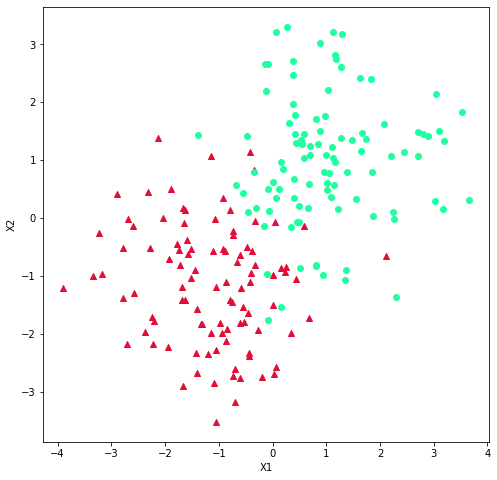

In [5]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:M//2,0], X[:M//2,1], marker='^', c='#e30e38')
plt.scatter(X[M//2:,0], X[M//2:,1], marker='o', c='#1fffa2')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

## Loss Surface Visualization

In [6]:
W1 = np.arange(-2, 2, 0.05)
W2 = np.arange(-2, 2, 0.05)
W1, W2 = np.meshgrid(W1, W2)
L = np.zeros(W1.shape)

In [7]:
for i in range(len(W1)):
    for j in range(len(W2)):
        model.w.assign([W1[0, i], W2[j, 0]])
        L[i, j] = model.loss(X, y)

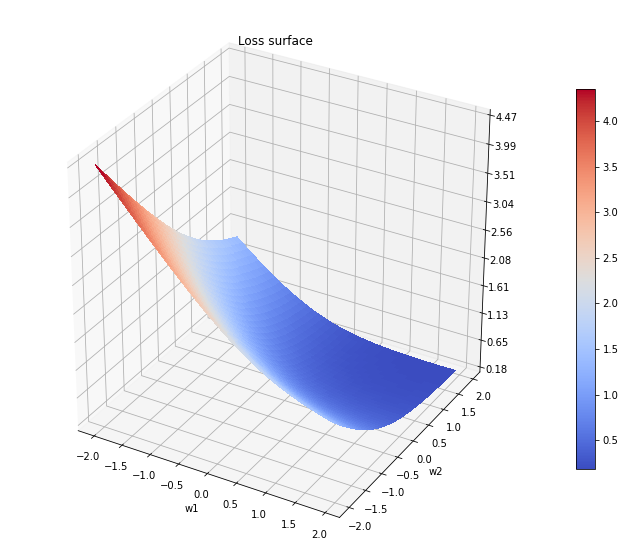

In [8]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(W1, W2, L, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.7)
plt.title("Loss surface")
plt.xlabel('w1')
plt.ylabel('w2')
plt.show()

## Gradient Descent

In [9]:
model.w.assign([0, 0])
optimizer = SGD(0.2)
gd_train_loss = [model.loss(X_train, y_train)]
gd_test_loss = [model.loss(X_test, y_test)]

In [10]:
for t in range(5):
    model.gradient_descent(X_train, y_train, optimizer)
    gd_train_loss.append(model.loss(X_train, y_train))
    gd_test_loss.append(model.loss(X_test, y_test))
    print(model.w.numpy())

[0.11355962 0.10807808]
[0.20752437 0.1966616 ]
[0.2864585  0.27024034]
[0.35409963 0.3324812 ]
[0.41317874 0.38607827]


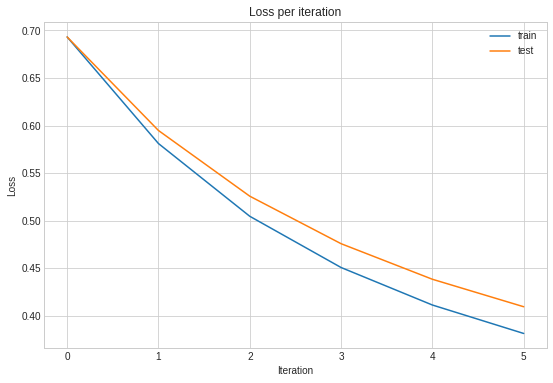

In [11]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(gd_train_loss, label='train')
plt.plot(gd_test_loss, label='test')
plt.legend()
plt.show()

## Newton Method

In [12]:
model.w.assign([0, 0])
optimizer = SGD(1)
nt_train_loss = [model.loss(X_train, y_train)]
nt_test_loss = [model.loss(X_test, y_test)]

In [13]:
for t in range(5):
    model.Newton_method(X_train, y_train, optimizer)
    nt_train_loss.append(model.loss(X_train, y_train))
    nt_test_loss.append(model.loss(X_test, y_test))
    print(model.w.numpy())

[0.6751735 0.5646712]
[1.2470112  0.88538384]
[1.8929702 1.1858484]
[2.4634967 1.4452342]
[2.7576294 1.5839043]


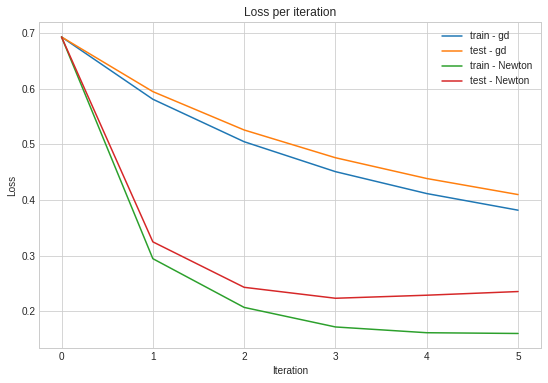

In [14]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(gd_train_loss, label='train - gd')
plt.plot(gd_test_loss, label='test - gd')
plt.plot(nt_train_loss, label='train - Newton')
plt.plot(nt_test_loss, label='test - Newton')
plt.legend()
plt.show()

## Natural Gradient Descent

When we update our model in its gradients direction, the new model's distribution might not be similar to the previous one. So in natural gradient descent, we consider all combinations of parameters that result in a new model, a constant distance away from the old model, and take step in the distribution space:

$$
\delta^* = \mathop{\text{arg min}}_{\delta \text{ s.t. } \text{KL}[p_w \Vert p_{w + \delta}] = c} \mathcal{L} (w + \delta),
$$
where $c$ is a constant, and KL-divergence measures the distance of two distributions.


Fisher information Matrix is the Hessian of KL divergence between two distributions $p(X|w)$ and $p(X|w')$ with respect to $w'$ and calculated at $w$:

$$
\text{F}_w = \nabla_{w'}^2 \, \text{KL}[p(X \vert w) \, \Vert \, p(X \vert w')]
$$

$\text{F}_w$ provides a local measure of distance. Intuitively, it gives the change in the distribution for a small change in parameters. So assuming $\delta \rightarrow 0$, we can approximate the KL-divergence by its second order Taylor series:

$$
\text{KL}[p(X \vert w) \, \Vert \, p(X \vert w + \delta)] \approx \frac{1}{2} \delta^\top \text{F}_w \delta
$$


Thus we could express $\mathop{\text{arg min}}_{\delta \text{ s.t. } \text{KL}[p_w \Vert p_{w + \delta}] = c} \mathcal{L} (w + \delta)$ as a Lagrangian, where the KL-divergence is approximated by $\frac{1}{2} \delta^\top \text{F}_w \delta$. By setting Lagrangian's derivative wrt. $\delta$ to zero, we obtain

$$
\delta = -\frac{1}{\lambda} \text{F}_w^{-1} \nabla_w \mathcal{L}(w),
$$

where $\lambda$ is a dual variable. We fold the scalar $\frac{1}{\lambda}$ into the learning rate to get the natural gradient decent formula:

$$
\tilde{\nabla}_w \mathcal{L}(w) = \text{F}_w^{-1} \nabla_w \mathcal{L}(w)
$$

In [15]:
model.w.assign([0, 0])
optimizer = SGD(0.2)
ng_train_loss = [model.loss(X_train, y_train)]
ng_test_loss = [model.loss(X_test, y_test)]

In [16]:
for t in range(5):
    model.natural_gradient_descent(X_train, y_train, optimizer)
    ng_train_loss.append(model.loss(X_train, y_train))
    ng_test_loss.append(model.loss(X_test, y_test))
    print(model.w.numpy())

[0.13503471 0.11293427]
[0.31936637 0.2510137 ]
[0.6049223  0.43484277]
[1.0953804  0.70332915]
[1.8137999 1.0452518]


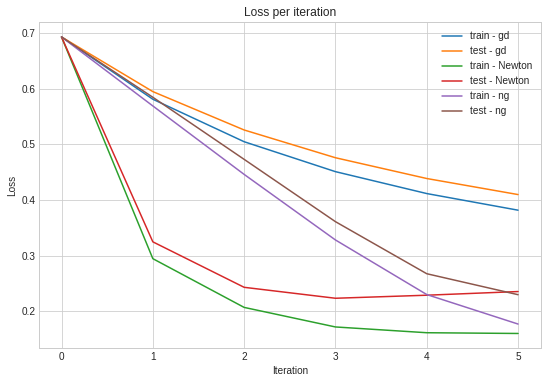

In [17]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(gd_train_loss, label='train - gd')
plt.plot(gd_test_loss, label='test - gd')
plt.plot(nt_train_loss, label='train - Newton')
plt.plot(nt_test_loss, label='test - Newton')
plt.plot(ng_train_loss, label='train - ng')
plt.plot(ng_test_loss, label='test - ng')
plt.legend()
plt.show()

## Linear Transformed Coordinates

In [18]:
W1 = np.arange(-2, 2, 0.05)
W2 = np.arange(-2, 2, 0.05)
W1, W2 = np.meshgrid(W1, W2)
L = np.zeros(W1.shape)

In [19]:
for i in range(len(W1)):
    for j in range(len(W2)):
        model.w.assign([W1[0, i], W2[j, 0]])
        L[i, j] = model.loss(X, y, 0.01)

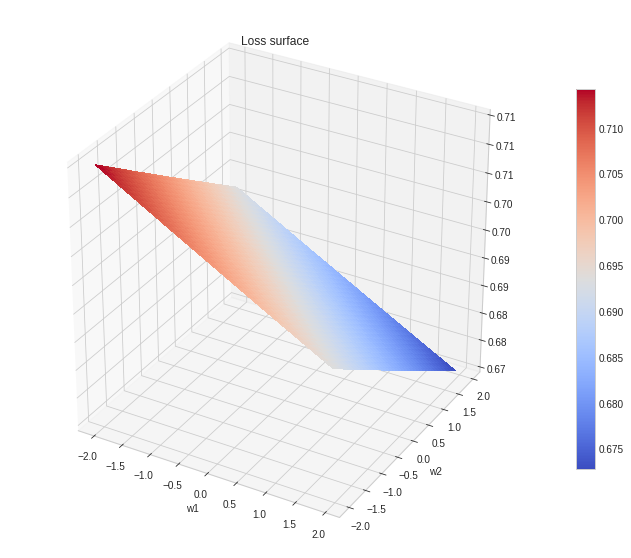

In [20]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(W1, W2, L, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.7)
plt.title("Loss surface")
plt.xlabel('w1')
plt.ylabel('w2')
plt.show()

## Gradient Descent

In [21]:
model.w.assign([0, 0])
optimizer = SGD(0.2)
gd_transformed_train_loss = [model.loss(X_train, y_train, 0.01)]
gd_transformed_test_loss = [model.loss(X_test, y_test, 0.01)]

In [22]:
for t in range(5):
    model.gradient_descent(X_train, y_train, optimizer, 0.01)
    gd_transformed_train_loss.append(model.loss(X_train, y_train, 0.01))
    gd_transformed_test_loss.append(model.loss(X_test, y_test, 0.01))
    print(model.w.numpy())

[0.0011356  0.00108078]
[0.00227117 0.00216154]
[0.00340673 0.00324228]
[0.00454227 0.004323  ]
[0.00567778 0.00540371]


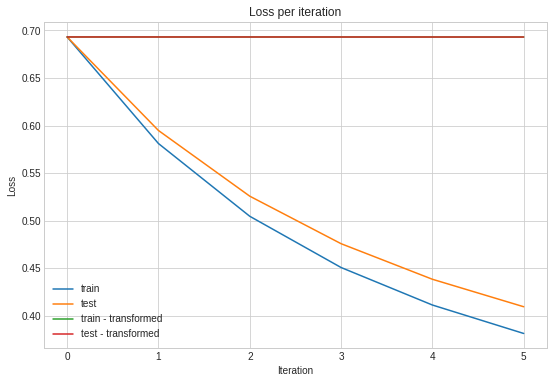

In [23]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(gd_train_loss, label='train')
plt.plot(gd_test_loss, label='test')
plt.plot(gd_transformed_train_loss, label='train - transformed')
plt.plot(gd_transformed_test_loss, label='test - transformed')
plt.legend()
plt.show()

## Newton Method

In [24]:
model.w.assign([0, 0])
optimizer = SGD(1)
nt_transformed_train_loss = [model.loss(X_train, y_train, 0.01)]
nt_transformed_test_loss = [model.loss(X_test, y_test, 0.01)]

In [25]:
for t in range(5):
    model.Newton_method(X_train, y_train, optimizer, 0.01)
    nt_transformed_train_loss.append(model.loss(X_train, y_train, 0.01))
    nt_transformed_test_loss.append(model.loss(X_test, y_test, 0.01))
    print(model.w.numpy())

[67.517365 56.46712 ]
[124.70111  88.5384 ]
[189.297   118.58485]
[246.34966 144.52342]
[275.76294 158.39043]


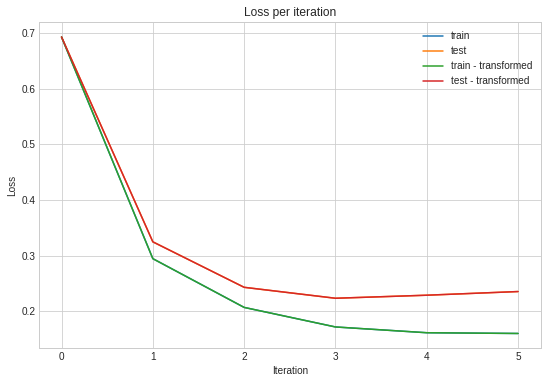

In [26]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(nt_train_loss, label='train')
plt.plot(nt_test_loss, label='test')
plt.plot(nt_transformed_train_loss, label='train - transformed')
plt.plot(nt_transformed_test_loss, label='test - transformed')
plt.legend()
plt.show()

## Natural Gradient Descent

In [27]:
model.w.assign([0, 0])
optimizer = SGD(0.2)
ng_transformed_train_loss = [model.loss(X_train, y_train, 0.01)]
ng_transformed_test_loss = [model.loss(X_test, y_test, 0.01)]

In [28]:
for t in range(5):
    model.natural_gradient_descent(X_train, y_train, optimizer, 0.01)
    ng_transformed_train_loss.append(model.loss(X_train, y_train, 0.01))
    ng_transformed_test_loss.append(model.loss(X_test, y_test, 0.01))
    print(model.w.numpy())

[13.503467 11.293429]
[31.936628 25.101374]
[60.492203 43.484287]
[109.538025  70.33294 ]
[181.38    104.52523]


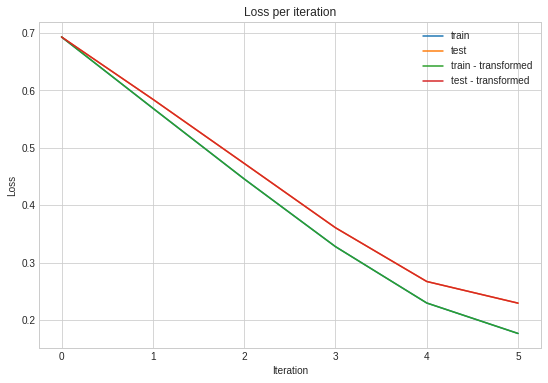

In [29]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(9, 6))
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(ng_train_loss, label='train')
plt.plot(ng_test_loss, label='test')
plt.plot(ng_transformed_train_loss, label='train - transformed')
plt.plot(ng_transformed_test_loss, label='test - transformed')
plt.legend()
plt.show()

## How the affine transformation affected?

The Newton method and natural gradient descent are affine invariant, implying that progress is independent of problem scaling. Thus, when the starting point is the same in both scenarios, the optimization path does not change. This is not true about gradient descent.

The gradient descent is not invariant under the affine transformation. When we scale coordinates by $0.01$, the gradients of the loss function is multiplied by $0.01$. Hence, in every point of the space, the step size is scaled by $0.01$ compared to that point in the untransformed coordinates. Consequently, the updates would cause smaller drops.

## Changes in the likelihood in Natural Gradient Descent

In [30]:
# Sort datapoints based on sum of coordinates
x_sorted, y_sorted = map(list, zip(*sorted(list(zip(X_train, y_train)), key=lambda tup: tup[0][0] + tup[0][1])))
x_sorted = np.array(x_sorted)
y_sorted = np.array(y_sorted)
x_axis = np.arange(n_train)

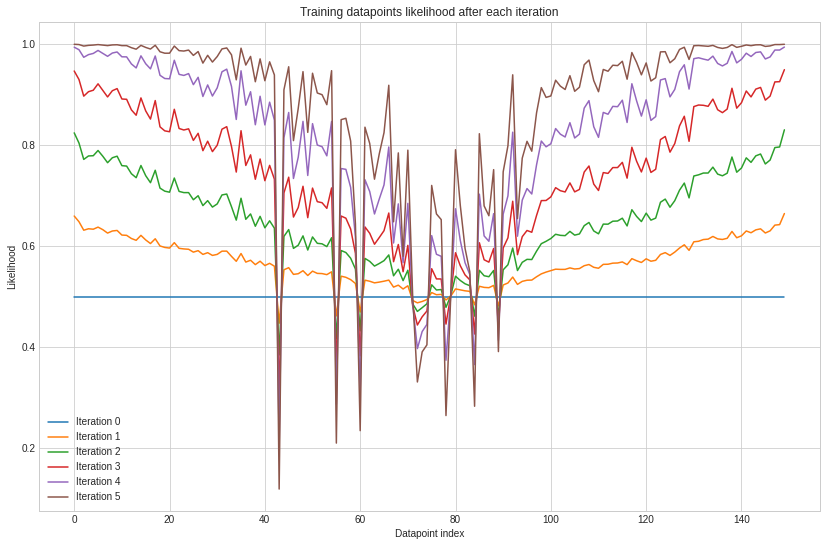

In [31]:
model.w.assign([0, 0])
preds = model.predict(x_sorted)
probs = (preds ** y_sorted) * ((1 - preds) ** (1 - y_sorted))

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14, 9))
plt.title('Training datapoints likelihood after each iteration')
plt.ylabel('Likelihood')
plt.xlabel('Datapoint index')
plt.plot(x_axis, probs, label = 'Iteration {}'.format(0))

optimizer = SGD(0.2)

for t in range(5):
    model.natural_gradient_descent(X_train, y_train, optimizer)
    preds = model.predict(x_sorted)
    probs = (preds ** y_sorted) * ((1 - preds) ** (1 - y_sorted))
    plt.plot(x_axis, probs, label = 'Iteration {}'.format(t+1))

plt.legend()
plt.show()

## Conclusion

The standard gradient has no information about the loss function's curvature because it is a first-order optimization method. It also manages all the parameters equally by multiplying them by a learning rate. When we combine the Hessian or Fisher matrix with the gradient, we are scaling the parameter updates with the curvature of the function. Moreover, second-order techniques treat each parameter concerning its influence on the loss function. They can use a constant learning rate with the guarantee of convergence when we are close to optima. The normal gradient is not invariant to affine transformations; however, Newton's step direction is affine invariant, and natural gradient update has more invariance than simply affine invariance.

Nevertheless, second-order methods have a severe pitfall in real-world problems: the number of deep learning models' parameters is enormous, so the calculation of the Hessian and Fisher Matrix and their inverse becomes an intractable problem. Some heuristics (e.g., RMSProp) are developed to somehow benefit from second-order knowledge by approximating the Fisher/Hessian. For example, ADAM calculates the running average of the second moment of the gradient, which is Fisher's approximation with constraining it to be a diagonal matrix. Therefore, space and time complexity for computing, storing, or inverting is linear.